# Crash Map Video

Make a video showing crashes over time on a map

Data source: https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-traffic-accidents

Based on: https://medium.com/udacity/creating-map-animations-with-python-97e24040f17b

In [1]:
import os
import pytz
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib._color_data import TABLEAU_COLORS

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM, Stamen
import pandas as pd
from tqdm.notebook import tqdm
import geopy
import geopy.distance

os.chdir('..')
from scripts.crash_data_analysis import CrashDataAnalysis
cda = CrashDataAnalysis()

In [2]:
# East Speer

# frame_directory = 'videos/speer'
# paste_center = [39.726591, -104.986417]
# miles_vertical = 0.9
# zoom_level = 16

In [3]:
# Westwood

# frame_directory = 'videos/kentucky'
# paste_center = [39.70039857002305, -105.03918676552246]
# miles_vertical = 1.7
# zoom_level = 15

In [4]:
# Downtown - Broadway / 20th St / California

# frame_directory = 'videos/downtown'
# paste_center = [39.74891627011233, -104.98736403434121]
# miles_vertical = 1.2
# zoom_level = 16

In [5]:
# CDOT HQ

frame_directory = 'videos/cdot'
paste_center = [39.738465044125576, -105.02321500866896]
miles_vertical = 0.5
zoom_level = 17

In [6]:
mrct = cda.most_recent_crash_timestamp()

date_first = pytz.timezone('America/Denver').localize(datetime(2022,1,1))
# date_last = datetime(2022,5,1) # df.crash_timestamp.max()
date_last = mrct + timedelta(days=28)

In [7]:
mrct

Timestamp('2024-02-07 19:53:00-0700', tz='America/Denver')

In [8]:
if not os.path.exists(frame_directory):
    os.makedirs(frame_directory)

In [9]:
d_vertical = geopy.distance.distance(miles=(miles_vertical)/2)
d_horizontal = geopy.distance.distance(miles=(miles_vertical * 1.25)/2)

center = geopy.Point(latitude=paste_center[0], longitude=paste_center[1])

bounds = {}
bounds['left'] = d_horizontal.destination(point=center, bearing=270).longitude
bounds['top'] = d_vertical.destination(point=center, bearing=0).latitude
bounds['right'] = d_horizontal.destination(point=center, bearing=90).longitude
bounds['bottom'] = d_vertical.destination(point=center, bearing=180).latitude

In [10]:
square_miles = (miles_vertical * 1.25) * miles_vertical
square_miles

0.3125

In [11]:
query = f"""
select 
*
, reported_date at time zone 'America/Denver' as reported_date_local

from crashes

where {bounds['left']} < geo_lon
and geo_lon < {bounds['right']}
and {bounds['bottom']} < geo_lat
and geo_lat < {bounds['top']}

and '{date_first}' <= reported_date at time zone 'America/Denver'
and reported_date at time zone 'America/Denver' <= '{date_last}'

order by reported_date
"""

df_in_bounds = pd.read_sql(query, cda.conn)

In [12]:
print('Stats about crash database: ')
print(f'Number of crashes: {len(df_in_bounds):,}')
print(f'Unique IDs: {df_in_bounds.incident_id.nunique():,}')
print(f'Min date: {df_in_bounds.reported_date_local.min()}')
print(f'Max date: {df_in_bounds.reported_date_local.max()}')

Stats about crash database: 
Number of crashes: 134
Unique IDs: 134
Min date: 2022-01-03 16:01:00
Max date: 2024-02-04 22:17:00


In [13]:
df_in_bounds['reported_date_local'] = df_in_bounds['reported_date_local'].dt.tz_localize('America/Denver')

In [14]:
stats_by_date = df_in_bounds.groupby('crash_date').agg(
    crashes=('incident_id', 'size')
    , fatalities=('fatality', 'sum')
    , serious_injuries=('sbi', 'sum')
    , pedestrians=('pedestrian_ind', 'sum')
    , bicycles=('bicycle_ind', 'sum')
)

# stats_by_date.to_clipboard()

stats_by_date.sum()

crashes             134.0
fatalities            5.0
serious_injuries      5.0
pedestrians          11.0
bicycles              1.0
dtype: float64

In [15]:
df_in_bounds['marker_shape'] = 'o' # circle
df_in_bounds.loc[df_in_bounds.pedestrian_ind > 0, 'marker_shape'] = 'D' # diamond
df_in_bounds.loc[df_in_bounds.bicycle_ind > 0, 'marker_shape'] = 's' # square

# https://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=4
# https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3
colors = {}
colors['crashes'] = '#1b9e77' # green
colors['serious_injuries'] = '#d95f02' # orange
colors['fatalities'] = '#7570b3' # purple

df_in_bounds['marker_color'] = colors['crashes']
df_in_bounds.loc[df_in_bounds.sbi, 'marker_color'] = colors['serious_injuries']
df_in_bounds.loc[df_in_bounds.fatality, 'marker_color'] = colors['fatalities']

In [16]:
# Save the base map
# todo: Stamen no longer supported
imagery = Stamen(style='toner-lite', cache=True)

/Users/devin/Projects/denver-street-data/env/lib/python3.10/site-packages/cartopy/io/img_tiles.py:116: UserWarning: Cartopy created the following directory to cache GoogleWTS tiles: /var/folders/4t/2xdd5b8965j2rjzd9rjml1xc0000gn/T/cartopy_cache_dir/Stamen
  warnings.warn(


In [17]:
fig = plt.figure(figsize=[16,9])
fig.subplots_adjust(left=0, bottom=0.05, right=0.7, top=0.95)

ax = plt.axes(projection=imagery.crs)
ax.add_image(imagery, zoom_level)
ax.set_extent((bounds['left'], bounds['right'], bounds['bottom'], bounds['top']))

# plt.savefig(f'{frame_directory}/base_map.png', facecolor='white')
plt.close()

In [18]:
video_date_range = pd.date_range(date_first, date_last, freq='d')

In [19]:
def save_one_frame(df, map_date, bounds, zoom_level, frame_filename, colors):
    """
    Save one frame of the video with crashes from that day and previous days
    
    df : DataFrame containing crashes (already limited to the bounds). If None, only base map is saved
    map_date : date for the crashes that will be plotted
    bounds : dict containing left (lon), right (lon), top (lat), and bottom (lat) bounds of the map
    frame_filename : the filename where to save the frame PNG
    colors : dict containing colors for 'crashes', 'serious_injuries', and 'fatalities'
    """

    fig = plt.figure(figsize=[16,9])

    fig.subplots_adjust(left=0, bottom=0.05, right=0.7, top=0.95)

    ax = plt.axes(projection=imagery.crs)
    ax.set_extent((bounds['left'], bounds['right'], bounds['bottom'], bounds['top']))
    ax.add_image(imagery, zoom_level)
    
    if frame_directory == 'videos/cdot':
        plt.gcf().text(
            x=0.35
            , y=0.53
            , s='Colorado Department\nof Transportation HQ'
            , fontsize=14
            , font='Menlo'
            , color='white'
            , backgroundcolor=TABLEAU_COLORS['tab:red']
            , horizontalalignment='center'
            , verticalalignment='center'
        )
    
    
    for days_back in range(27,-1,-1):
        
        rows_to_plot = df.crash_date == (map_date - timedelta(days=days_back)).strftime('%Y-%m-%d')

        if rows_to_plot.sum() > 0:
            for m in df[rows_to_plot]['marker_shape'].unique():
                for c in df[rows_to_plot]['marker_color'].unique():
                    
                    # Make the crashes fade out sooner than the injuries and fatalities
                    if c == colors['crashes']:
                        fill_style='none'
                        if days_back >= 14:
                            alpha_value = 0
                        elif days_back >= 7:
                            alpha_value = 0.8 - (0.1 * (days_back - 6))
                        else:
                            alpha_value = 0.8

                    else: # fatalities and serious injuries
                        fill_style = 'full'
                        if days_back >= 21:
                            alpha_value = 0.8 - (0.1 * (days_back - 20))
                        else:
                            alpha_value = 0.8


                    ax.plot(
                        df.loc[
                            (rows_to_plot) & (df['marker_shape'] == m) & (df['marker_color'] == c)
                            , 'geo_lon'
                            ].to_numpy()
                        , df.loc[
                            (rows_to_plot) & (df['marker_shape'] == m) & (df['marker_color'] == c)
                            , 'geo_lat'
                            ].to_numpy()
                        , transform=ccrs.Geodetic()
                        , marker=m
                        , color=c
                        , linestyle=''
                        , markersize=(5*(days_back+1)) + 10
                        , fillstyle=fill_style
                        , markeredgewidth=6
                        , alpha=alpha_value
                    )


    # Do counts of crashes up to map_date
    counts = df[df.reported_date_local <= map_date].groupby('crash_date').agg(
        crashes=('incident_id', 'size')
        , fatalities=('fatality', 'sum')
        , serious_injuries=('sbi', 'sum')
        , pedestrians=('pedestrian_ind', 'sum')
        , bicycles=('bicycle_ind', 'sum')
    ).sum()    
    
    if map_date > mrct:
        date_for_legend = mrct.strftime('%Y-%m-%d')
    else:
        date_for_legend = map_date.strftime('%Y-%m-%d')
        
    legend = [
        ('Date: {}'.format(date_for_legend), 'black', 0.91)
        , ('Car crashes:{: 6,.0f}'.format(counts['crashes']), colors['crashes'], 0.78)
        , ('Crashes with a       \nserious injury:{: 6,.0f}'.format(
            counts['serious_injuries']), colors['serious_injuries'], 0.6175)
        , ('Crashes with a       \nfatality:{: 6,.0f}'.format(counts['fatalities']), colors['fatalities'], 0.455)
        , (u"\n\u25C7 Pedestrian       \ninvolved:{: 6,.0f}".format(counts['pedestrians']), 'black', 0.2925)
        , (u"\n\u25FB Bicycle       \ninvolved:{: 6,.0f}".format(counts['bicycles']), 'black', 0.13)
    ]
    
    for idx, line in enumerate(legend):
            
        plt.gcf().text(
            x=0.97
            , y=line[2]
            , s=line[0]
            , fontsize=26
            , horizontalalignment='right'
            , verticalalignment='bottom'
#             , family='monospace'
            , font='Menlo'
            , color=line[1]
        )

    plt.gcf().text(
        x=0.97
        , y=0.05
        , s='Visualization by Devin Brady'
        , fontsize=18
        , horizontalalignment='right'
#         , family='monospace'
        , font='Menlo'
        , color='black'
    )

    plt.savefig(frame_filename, facecolor='white')
    plt.close()
    
    return legend

In [20]:
# Save the initial map
_ = save_one_frame(
    pd.DataFrame(columns=df_in_bounds.columns)
    , video_date_range[0]
    , bounds
    , zoom_level
    , f'{frame_directory}/initial_map.png'
    , colors
)

<urlopen error [Errno 8] nodename nor servname provided, or not known><urlopen error [Errno 8] nodename nor servname provided, or not known>

<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlop

Saving map frames:   0%|          | 0/796 [00:00<?, ?it/s]

KeyboardInterrupt: 

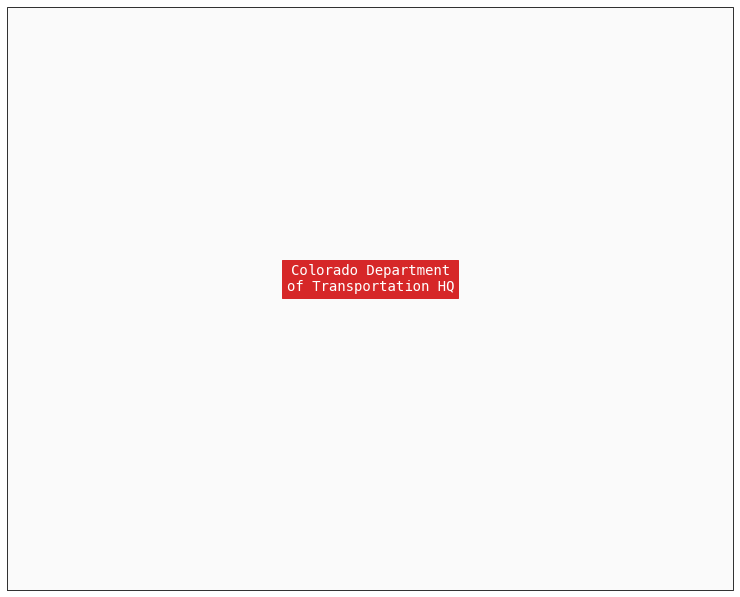

In [21]:
for counter, d in enumerate(tqdm(video_date_range, 'Saving map frames')):

    # only save the last image
#     if counter < 364:
#         continue
    
    legend = save_one_frame(df_in_bounds, d, bounds, zoom_level, f'{frame_directory}/frame_{counter:04d}.png', colors)


## Terminal command 

In [ ]:
print(
    f'ffmpeg -framerate 12 -i {frame_directory}/frame_%4d.png -c:v h264 -r 30 '
    + f'-s 1920x1080 {frame_directory}/crashes.mp4'
)

In [ ]:
# import numpy as np
# np.linspace(0.75, 0.1, num=5)

In [ ]:
# import matplotlib
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf') #[:10]

In [ ]:
for leg in legend:
    print(leg[0])

In [ ]:
df_in_bounds[df_in_bounds.fatality]